```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} sample average approximation
```
```{index} stochastic optimization
```
```{index} chance constraints
```

# Economic dispatch in energy systems

In [ ]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

In [9]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Economic dispatch of energy

In this notebook, we will explore the applications of chance constraints to an area where high-probability guarantees on the system's functioning are required - the _economic dispatch (ED)_ problem.

The problem considers short-term determination of the optimal production of energy to meet all energy demand. Let $V$ denote a set of nodes, each of which is representing cities, industrial districts, or power generators or combinations of these. Each node $i \in V$ **may** have:
- a certain energy demand $d_i \geq 0$; 
- a power generator whose energy production needs to be between $p_i^{min}$ and $p_i^{max}$ units of power. The cost of producting one unit of power at node $i$ is given by a variable cost $c_i \geq 0$. 
Importantly, not all the nodes have demand and generation, more specifically it is possible for a node to have only generation or only demand.

The goal is to determine for each node $i \in V$ the optimal production level $p_i$, such that 
- the total energy demand is met
- no production limits are exceeded
- the total energy production costs are minimized. 

If we fully control the energy production and the customer demand is known, can formulate the problem as the following MILO problem:
$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i\\
\text{s.t.} & \sum_{i \in V} p_i = \sum_{i \in V} d_i,\\
& p_{i}^{min} \leq p_{i} \leq p_{i}^{max} & \forall i \in V.
\end{array}
\end{align}
$$

Now, assume that we have built several off-shore wind turbines. These wind turbines combined together produce a random nonnegative amount of extra energy, denoted by $\omega$. For a fixed value of $\omega$, the optimization proble to be solved is thus to 'fill in' to the remaining energy demand not satisfied by wind power:

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i\\
\text{s.t.} & \omega + \sum_{i \in V} p_i = \sum_{i \in V} d_i,\\
& p_{i}^{min} \leq p_{i} \leq p_{i}^{max} & \forall i \in V.
\end{array}
\end{align}
$$

The problem, however, is that $\omega$ is a random variable and is typically not fully known before the generation levels $p_i$ of conventional generators have to be set. Because of stochastic fluctuations in wind power generation, the ED problem is best modeled as a stochastic optimization problem. The intermittency of wind generation makes it almost impossible to perfectly balance supply and demand on a real-time basis, but in practice there is some tolerance for error, i.e., certain degree of mismatch between supply and demand can be easily adjusted for. 

To formulate the problem under this assumption, let us denote by:
- $\Delta \geq 0$ the tolerance of the absolute power mismatch between supply and demand;
- $\varepsilon \in [0,1]$ is the risk level at which we are willing to accept for the supply to deviate from the demand more than $\Delta$;
- $\omega \in \mathbb{R}_{\geq 0}$ the nonnegative random variable describing the total power production of off-shore wind turbines.

In this setting, instead of requiring that the supply and demand are matched perfectly, we require that the absolute difference remains below power threshold $\Delta$ using the following chance constraint:

$$
\begin{align}
  \mathbb{P} \Big ( \Big | \omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \Big | \leq \Delta \Big) \geq 1 - \varepsilon
\end{align}
$$

To make the problem MILO-formulable, we can break up this absolute-value function including constraint into two individual chance constraints - note that in this way we relax the constraint because requiring that two one-sided constraints hold with probability $1 - \varepsilon$ each is not the same as requiring that together they hold with probability $1 - \varepsilon$, but in practice we can fine-tune the $\varepsilon$ to adapt for this change.

Such breaking up leads us to the following optimization problem with chance constraints:

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V } c_i p_i\\
\text{s.t.} & \mathbb{P}(\omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \leq \Delta) \geq 1 - ɛ\\
& \mathbb{P}(\omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \geq -\Delta) \geq 1 - ɛ\\
& p_{i}^{min } \leq p_{i} \leq p_{i}^{max } & \forall i \in V.
\end{array}
\end{align}
$$

In this notebook, we will solve this problem using the SAA approach to chance constraints, with the wind power production using modelled with historical data of 500 outcomes of the total wind producton.

We first build a function that reads all the necessary node and wind production random sample data.

In [3]:
def read_economic_dispatch_data():
    nodes_df = pd.read_csv(
        "nodes.csv",
        index_col=0,
    )[["node_id", "d", "p_min", "p_max", "c_var"]]

    wind_production_samples_df = pd.read_csv(
        "discrete_wind.csv"
    ).T

    # Read data
    nodes = nodes_df.set_index("node_id").T.to_dict()
    wind_production_samples = list(wind_production_samples_df.to_dict().values())
    wind_production_samples = [sum(d.values()) for d in wind_production_samples]

    return nodes, wind_production_samples

nodes, wind_production_samples = read_economic_dispatch_data()

The `nodes` dictionary contains for every $i \in V$ information about $p_i^{min}$, $p_i^{max}$, $c_i$, $d_i$. In our dataset, there is a clear separation of the nodes into nodes that only consume power, and nodes that only produce power, which can be seen by inspecting the node properties.

In [4]:
nodes[0] # first node properties

{'d': 44.23034433319671, 'p_min': 0.0, 'p_max': 0.0, 'c_var': 0.0}

The wind production samples can be accessed through the `wind_production_samples` variable - a list of 500 equiprobable outcomes for the wind generation.

In [6]:
wind_production_samples[4] # fifth outcome

196.94632359541376

With data at hand, we rewrite the chance-constrained ED problem as a mixed-integer linear optimization problem:

\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i(p_i)\\
\text{s.t.} & \omega_j + \sum_{i \in V} p_i  - \sum_{i \in V} d_i \leq \Delta + u_jM_j & \forall j = 1, \dots, N\\
&  \omega_j + \sum_{i \in V} p_i  - \sum_{i \in V} d_i \geq -\Delta - u_jM_j & \forall j = 1, \dots, N\\
& \sum_{j=1}^{N}u_j \leq \varepsilon N \\
& p_{i}^{min } \leq p_{i} \leq p_{i}^{max } & \forall i \in V, \\
& u_j \in \{0, 1\} & \forall j = 1, ..., N,
\end{array}
\end{align}

where we introduce a new binary variable $u_j$ for each sample $j=1, \dots, N$. For each sample, the supply and demand constraints are deactivated when $u_j =1$ and $u_j=0$ otherwise. Note that we only use one single $u_j$ variable for each constraint. Having two separate $u^{(1)}_j$ and $u^{(2)}_j$ will yield the same objective value, but the model is incorrect w.r.t. the violation of the supply and demand constraint introduced earlier. The $M_j$'s here should be selected based on the data: one reasonable choice for $M_j$ that will certainly work out is to take it equal to the left-hand side minus $\Delta$ while replacing $p_i$ for $p_i^{max}$.

Now, we define the Python function which implements this model.

In [10]:
def economic_dispatch(nodes, samples, eps, Delta):
    # Define a model
    model = pyo.ConcreteModel("Q1")

    model.N = pyo.Set(initialize=range(len(samples)))
    model.nodes = pyo.Set(initialize=nodes.keys())

    M = {j: (samples[j] +
          sum(data['p_max'] for _, data in nodes.items()) +
          sum(data['d'] for _, data in nodes.items()) - Delta)
          for j in range(len(samples))}

    # Declare decision variables
    model.p = pyo.Var(nodes, domain=pyo.NonNegativeReals)
    model.u = pyo.Var(model.N, domain=pyo.Binary)

    # Declare objective value
    @model.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(data["c_var"] * m.p[i] for i, data in nodes.items())


    @model.Constraint(model.N)
    def supply_demand_leq(m, j):
        wind = samples[j]
        supply = sum(m.p[i] for i, data in nodes.items())
        demand = sum(data['d'] for _, data in nodes.items())
        return wind + supply - demand  <= Delta + M[j] * m.u[j]

    @model.Constraint(model.N)
    def supply_demand_geq(m, j):
        wind = samples[j]
        supply = sum(m.p[i] for i, data in nodes.items())
        demand = sum(data['d'] for _, data in nodes.items())
        return wind + supply - demand  >= -Delta - M[j] * m.u[j]

    @model.Constraint()
    def success_probability(m):
        return sum(m.u[j] for j in model.N) <= eps * len(model.N)

    @model.Constraint(model.nodes)
    def generation_upper_bound(m, i):
        return m.p[i] <= nodes[i]["p_max"]

    @model.Constraint(model.nodes)
    def generation_lower_bound(m, i):
        return nodes[i]["p_min"] <= m.p[i]

    return model

For demonstration purposes, we now solve the model for the provided instance and wind production outcomes and report the optimal objective value you obtain for $\varepsilon = 0.02$ and $\Delta=1000$.

In [13]:
# Data
eps = 0.20
Delta = 1000
N = 500
argMin = int(N*eps)

# Solve model
model = economic_dispatch(nodes, wind_production_samples, eps, Delta)
result = pyo.SolverFactory('cbc').solve(model)

# The production is equal to the total demand - Delta - smallest_wind_production
sum_production = sum([model.p[x].value for x in model.p])
sum_demand = sum(data['d'] for i, data in nodes.items())
smallest_wind_production =  sorted([wind_production_samples[j] for j in range(N)])[argMin]

print("Total demand:", sum_demand)
print("Delta:", Delta)
print("Smallest wind production", smallest_wind_production)
print("Model solution of total production:", sum_production)

# The total production should be produced by the cheapest generators.
print("Analytical solution of total production:", sum_demand - Delta - smallest_wind_production)

Total demand: 3007.112013689768
Delta: 1000
Smallest wind production 273.71861055345124
Model solution of total production: 1733.3934100000001
Analytical solution of total production: 1733.3934031363167


Next, we will study the sensitivity of the optimal solution and value to the different risk guarantee levels - this helps the decision maker find a level that offers the best risk-reward tradeoff.

To this end, we solve the same MILP varying the values first of $\varepsilon \in [0, 1]$ (for fixed $\Delta=1000$) and then of $\Delta \in [0, 2000]$ (for fixed $\varepsilon = 0.02$).     

Text(0, 0.5, 'objective value')

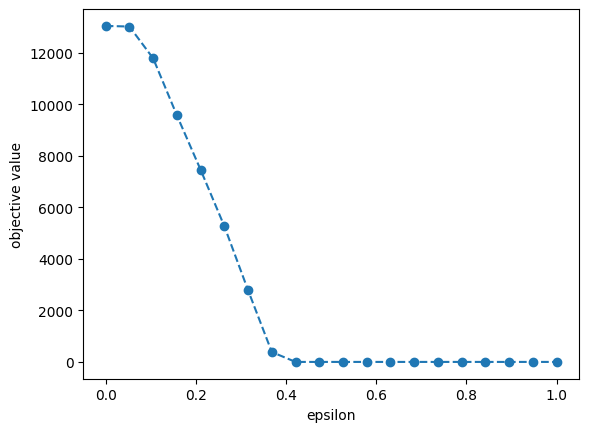

In [14]:
fixed_Delta = 1000

feas_eps = []
feas_objs = []

for eps in np.linspace(0, 1, num=20):
    model = economic_dispatch(nodes, wind_production_samples, eps, fixed_Delta)
    result = pyo.SolverFactory('cbc').solve(model)

    if result.solver.termination_condition == 'optimal':
        feas_eps.append(eps)
        feas_objs.append(model.objective())

plt.plot(feas_eps, feas_objs, marker='o', linestyle='--')
plt.xlabel('epsilon')
plt.ylabel('objective value') 

    model.name="Q1";
      - termination condition: infeasible
      - message from solver: <undefined>
    model.name="Q1";
      - termination condition: infeasible
      - message from solver: <undefined>
    model.name="Q1";
      - termination condition: infeasible
      - message from solver: <undefined>
    model.name="Q1";
      - termination condition: infeasible
      - message from solver: <undefined>
    model.name="Q1";
      - termination condition: infeasible
      - message from solver: <undefined>


Text(0, 0.5, 'objective value')

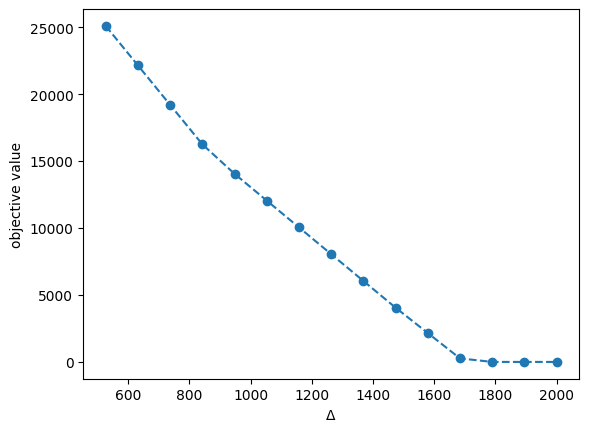

In [17]:
fixed_eps = 0.02

feas_Deltas = []
feas_objs = []

for Delta in np.linspace(0, 2000, num=20):
    model = economic_dispatch(nodes, wind_production_samples, fixed_eps, Delta)
    result = pyo.SolverFactory('cbc').solve(model)

    if result.solver.termination_condition == 'optimal':
        feas_Deltas.append(Delta)
        feas_objs.append(model.objective())

plt.plot(feas_Deltas, feas_objs, marker='o', linestyle='--')
plt.xlabel('$\Delta$')
plt.ylabel('objective value') 

Based on the above plots, we can make the following observations:

- Smaller values $\varepsilon$ and $\Delta$ lead to more infeasibilities, which is to be expected. Smaller $\varepsilon$ allow for less constraint violations/relaxations, whereas smaller Delta make constraints tighter (and thus easier to violate).
- The reason why the plot becomes flat for high $\varepsilon$ and $\Delta$ values is because production is no longer needed. For instance, a high $\varepsilon$ means we can ignore the $N\varepsilon$ worst-case sample scenarios, whereas higher $\Delta$ means that we do not need to produce to match demand.

## Analytical solution instead of using optimization solvers for speed improvement

A careful reader may notice that in fact, the above optimization problems could have been solved analytically, i.e., we wouldn't even need optimization solvers to do our job. 

This is because the (deterministic) Economic Dispatch problem is always solved by producing using the cheapest generators. Therefore, any optimal solution will always use the cheapest generators possible. It will never violate the supply-demand balance by overproduction, since producing less will always lead to cheaper solutions.

How this reasoning can be extended to the stochastic case? By adding chance constraints where the outcomes follow a equiprobable discrete distribution, we know that scenarios with low wind production will be violated before the scenarios with large wind production. Therefore, given $\varepsilon$ and $\Delta$, what will happen is that the $N\varepsilon$ (rounded down) samples with lowest wind production will be deactivated. Therefore, the exact total production will be 

$$
\sum_{i \in V} p_i = \sum_{i \in V}d_i - \Delta - \Omega
$$

where $\Omega$ is the $N\varepsilon$-th sample with smallest wind production. The $p_i$ can be determined by selecting the cheapest generators first.

This fact teaches us an important lesson - it always makes sense to take a look at the structure of the problem at hand. It might turn out that we are able to come up with an analytical solution that can be found out in a few simple steps (or manually break down a big optimization problem into a number of smaller ones that can be solved easier).

While this might not make a difference for problems that are solved once (time saved on coming up with an analytical solution might be too short compared to time saved on not using an optimization solver). However, when the optimization problem needs to be solved many, many times (for example, in a long-horizon simulation), the effort might pay off as the analytical-solution based simulation might work much faster than the one that explicitly calls an optimization solver every time).

For a simple calculation, let's imagine that formulating the problem in Pyomo and solving it with any solver takes 0.5s per run (not unreasonable). Now, having an analytical solution to the problem can easily change this timing to 0.001s per run. Clearly, a difference of practically 0.5s is not worth spending the extra time.

However, if this daily problem has to be solved 10000 times for a simulation of a power grid's performance. Then the total time spent becomes 5000s = 1.5h vs 10s = 1.5min, so the difference between the two is 1.5h. Now, imagine that you need to run many such simulations. The difference of 1.5h between the two simulations gets then multiplied by the number of simulations and thus, writing a simple code that finds the analytical solution fast, pays off easily.